In [199]:
from __future__ import annotations
import typing
from dataclasses import dataclass, field
import warnings
from contextlib import contextmanager
import itertools

In [200]:
import numpy as np
import matplotlib.pyplot as plt

In [201]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]
    
    if not restore_values:
        return
    
    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [202]:
# To please the linter a bit.
# Not actually meant to represent types, but rather array shapes.
N = typing.TypeVar("N")
M = typing.TypeVar("M")

In [203]:
@dataclass
class PointSet:
    xs: np.ndarray['N'] = field(default_factory=lambda: np.array([]))
    fs: np.ndarray['N'] = field(default_factory=lambda: np.array([]))
    
    def add_point(self, x: float, f: float):
        self.xs = np.append(self.xs, x)
        self.fs = np.append(self.fs, f)
    
    def clear(self):
        self.xs = np.array([])
        self.fs = np.array([])
    
    def __len__(self):
        return len(self.xs)
    
    def __iter__(self):
        return zip(self.xs, self.fs)
    
    @property
    def steps(self) -> np.ndarray['N - 1']:
        return np.diff(self.xs - 1)


In [212]:
@dataclass
class CubicSpline:
    xs: np.ndarray['N']
    polys: np.ndarray['N-1,4']  # a x^3 + b x^2 + c x + d
    
    @property
    def range(self) -> typing.Tuple[float, float]:
        return self.xs[0], self.xs[-1]
    
    def __contains__(self, x: float) -> bool:
        return self.range[0] <= x <= self.range[1]
    
    def __call__(self, x: float) -> float:
        if isinstance(x, np.ndarray):
            return np.array([self(xi) for xi in x])
        
        if x not in self:
            raise ValueError("x is out of bounds")
        
        i = np.searchsorted(self.xs, x) - 1
        if i == -1:
            i = 0
        return np.polyval(self.polys[i], x - self.xs[i])


In [205]:
def solve_sweep(
    a: np.ndarray['N-1'],
    b: np.ndarray['N'],
    c: np.ndarray['N-1'],
    f: np.ndarray['N'],
) -> np.ndarray['N']:
    """
    Note: b should not be inverted in the invocation.
    """
    
    a: np.ndarray['N'] = np.insert(a, 0, 0)
    c: np.ndarray['N'] = np.append(c, 0)
    b = -b
    
    # p[0] and q[0] are ignored
    p: np.ndarray['N-1'] = np.zeros_like(a, dtype=float)
    q: np.ndarray['N-1'] = np.zeros_like(a, dtype=float)
    
    p[1] = c[0] / b[0]
    q[1] = -f[0] / b[0]
    
    for i in range(1, len(a) - 1):
        p[i + 1] = c[i] / (b[i] - a[i] * p[i])
        q[i + 1] = (a[i] * q[i] - f[i]) / (b[i] - a[i] * p[i])
    
    x: np.ndarray['N'] = np.zeros_like(a)
    x[-1] = (a[-1] * q[-1] - f[-1]) / (b[-1] - a[-1] * p[-1])
    
    for i in range(len(a) - 1, 0, -1):
        x[i - 1] = p[i] * x[i] + q[i]
    
    return x


In [206]:
def create_spline(points: PointSet) -> CubicSpline:
    assert len(points) >= 2
    
    polys: np.ndarray['N-1,4'] = np.zeros((len(points) - 1, 4))
    h: np.ndarray['N-1'] = points.steps
    
    c: np.ndarray['N-2'] = solve_sweep(
        h[1:-1],
        2 * (h[:-1] + h[1:]),
        h[1:-1],
        3 * ((points.fs[2:] - points.fs[1:-1]) / h[1:] - (points.fs[1:-1] - points.fs[:-2]) / h[:-1]),
    )
    
    # Note: c_0 = c_n = 0
    c = np.hstack((0, c, 0))
    
    # populate d
    d = np.zeros_like(c)
    for i in range(len(polys)):
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])
    
    # populate b
    b = np.zeros_like(c)
    for i in range(len(polys)):
        b[i] = (points.fs[i + 1] - points.fs[i]) / h[i] - h[i] * (c[i + 1] + 2 * c[i]) / 3
    
    polys[:, 3] = points.fs[:-1]
    polys[:, 2] = b[:-1]
    polys[:, 1] = c[:-1]
    polys[:, 0] = d[:-1]
    
    return CubicSpline(points.xs, polys)
    

In [207]:
def spline_over_grid(func: typing.Callable[[float], float], grid: np.ndarray['N']) -> CubicSpline:
    points = PointSet()
    
    for x in grid:
        points.add_point(x, func(x))
    
    return create_spline(points)


In [208]:
def show_grid(
    func: typing.Callable[[float], float],
    grid: np.ndarray['N'],
    name: str = "Spline",
    ax: typing.Optional[plt.Axes] = None,
) -> CubicSpline:
    spline = spline_over_grid(func, grid)
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    fig: plt.Figure
    ax: plt.Axes
    
    ax.set_title(name)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    xs = np.linspace(grid[0], grid[-1], 1000)
    # xs = np.linspace(grid[0] + 1e-6, grid[-1] - 1e-6, 1000) 
    
    ax.plot(xs, func(xs), label="func", color="C0")
    ax.plot(xs, spline(xs), label="spline", color="C1")
    ax.plot(grid, func(grid), "o", label="grid", color="C2")
    
    ax.legend()
    
    return spline
    

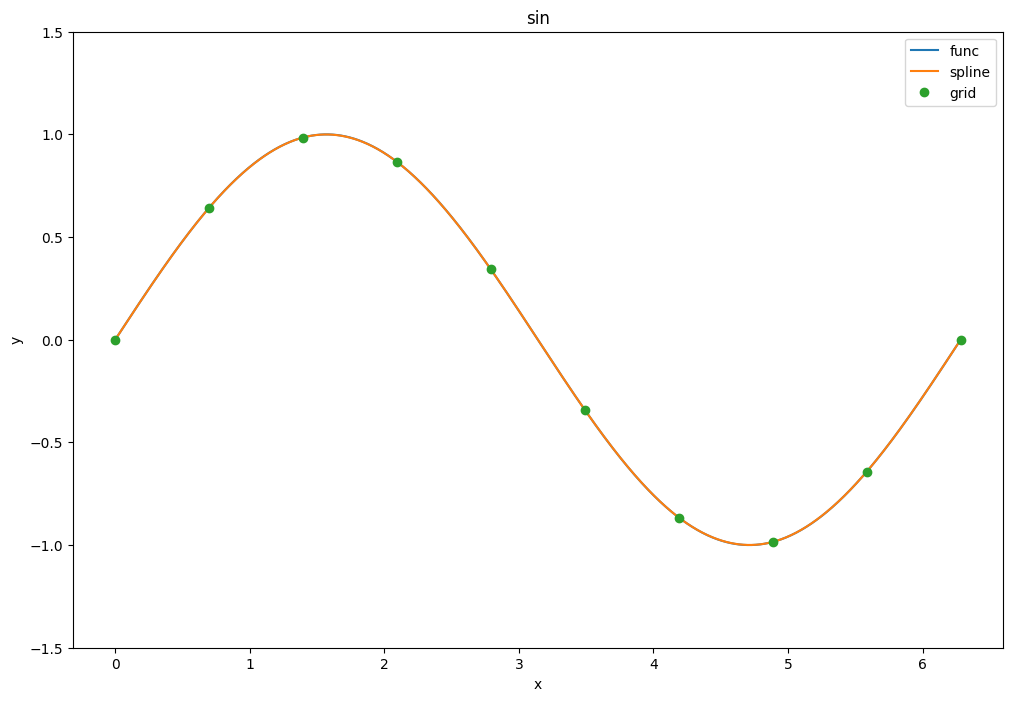

In [213]:
with localize_globals():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.set_ylim(-1.5, 1.5)
    
    show_grid(np.sin, np.linspace(0, 2 * np.pi, 10), name="sin", ax=ax)